# Objective or Steps
### 1. Extract relevant data(email bodies)
### 2. Convert format from .txt files to DataFrame
### 3. Check for empty emails
### 4. Check for null or missing values 
### 5. Remove all rows with bad data


# Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from os import walk
from os.path import join

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud

from PIL import Image
from sklearn.model_selection import train_test_split



%matplotlib inline


# System FileSystem

In [2]:
print(sys.getfilesystemencoding())

utf-8


# Constants

In [110]:
SPAM_1_PATH = 'spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DOC_JSON_FILE = 'spam_assassin_corpus/email-text-data.json'
WORD_ID_FILE = 'spam_assassin_corpus/word-by-id.csv'
TRAINING_DATA_FILE = 'spam_assassin_corpus/train-data.txt'
TRAINING_DATA_FILE_CSV = 'spam_assassin_corpus/train-data.csv'
TEST_DATA_FILE = 'spam_assassin_corpus/test-data.txt'



WHALE_FILE = 'spam_assassin_corpus/wordcloud_resources/whale-icon.png'
THUMPS_UP_FILE = 'spam_assassin_corpus/wordcloud_resources/thumbs-up.png'
THUMPS_DOWN_FILE = 'spam_assassin_corpus/wordcloud_resources/thumbs-down.png'


# Generator Function for Email Body Extraction

In [4]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            
            is_body = False
            lines = []
            
            for line in  stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                    
            stream.close()
            
            email_body = '\n'.join(lines)
 
            yield file_name, email_body
        

In [5]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name,email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [6]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails.head()


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [7]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [8]:
spam_emails.shape

(1898, 2)

In [9]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [10]:
ham_emails.shape

(3901, 2)

In [11]:
data = pd.concat([spam_emails, ham_emails])
print('Shape entire dataframe is ', data.shape)
data.head()

Shape entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [12]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning: Checking for Missing values

In [13]:
# check if any message bodies are null
data.MESSAGE.isnull().values.any()

False

In [14]:
# check if there are empty emails (string length zero) 
(data.MESSAGE.str.len() == 0).any()

True

In [15]:
# check number of entries with empty emails 
(data.MESSAGE.str.len() == 0).sum()

3

In [16]:
# check number of entries with null/None values
data.MESSAGE.isnull().sum()

0

# Locate empty emails

In [17]:
type (data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [18]:
data[data.MESSAGE.str.len() == 0].index
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

In [19]:
# Remove empty entries from dataFrame
data.drop(['cmds'], inplace = True)

In [20]:

data[data.MESSAGE.str.len() == 0].index

Index([], dtype='object')

In [21]:
data.shape


(5796, 2)

### Add Document IDs to Track Emails in Dataset

In [22]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [23]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace = True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [24]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save a File using Pandas

In [25]:
data.to_json(DOC_JSON_FILE)

# Data Visualisation 
### Number of Spam Messages Visualised (Pie Charts)

In [26]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [27]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

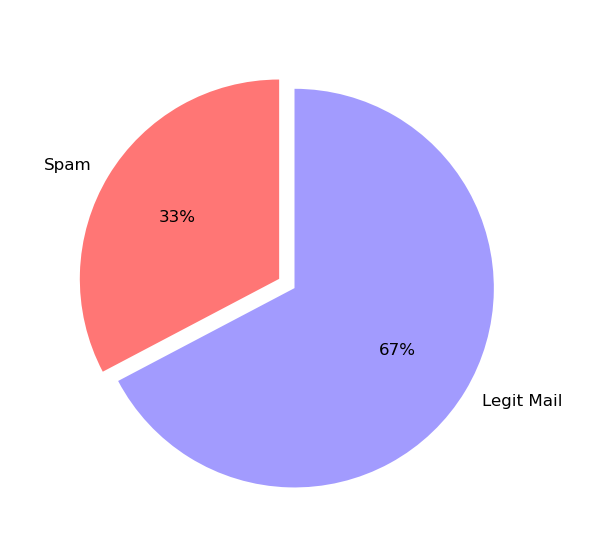

In [28]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#a29bfe']
explod_prop = [0,0.09]
#ff7675
#d63031
#a29bfe

plt.figure(figsize = (2.2,2.2), dpi = 300)
plt.pie(sizes, labels=category_names, textprops = {'fontsize': 4}, startangle=90,
autopct='%1.0f%%', colors= custom_colors,explode= explod_prop)
plt.show()


#### Donut Chart

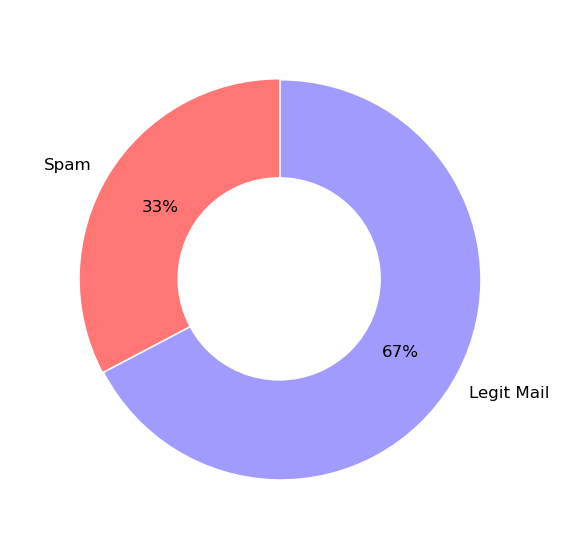

In [29]:
plt.figure(figsize = (2.2,2.2), dpi = 300)
plt.pie(sizes, labels=category_names, textprops = {'fontsize': 4}, startangle=90,
autopct='%1.0f%%', colors= custom_colors, pctdistance= 0.7, explode=[0, 0.01])


# Draw a circle 
centre_circle = plt.Circle((0,0), radius= 0.5, color = '#fff')
plt.gca().add_artist(centre_circle)

plt.show()


# Natural Language Processing 
#### Text Pre-Processing Steps

##### 1. Converting to lower case
##### 2. Removing stop words
##### 3. Stripping HTML tags
##### 4. Word stemming
##### 5. Removing punctuations

In [30]:
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

##### Download the NLTK Resources (Tokenizer & Stopwords)

In [31]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91998\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91998\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Tokenising

In [32]:
msg = 'All work and no play makes Jack a dull boy.'
words =  word_tokenize(msg.lower()) 

#### Removing stop words

In [33]:
stop_words = set(stopwords.words('english'))

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']


#### Word Stems and stemming 

In [34]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Life of a boy lived like a man is always life of dead@343322223322@@@'
words =  word_tokenize(msg.lower())

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'life', 'boy', 'live', 'like', 'man', 'alway', 'life', 'dead', '@', '343322223322', '@', '@', '@']


#### Remove Punctuation 

In [35]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Life of a boy lived like a man is always life of dead@343322223322@@@'
words =  word_tokenize(msg.lower())

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'life', 'boy', 'live', 'like', 'man', 'alway', 'life', 'dead']


#### Remove HTML tags from Emails

In [36]:
data_modified = data.at[0, 'MESSAGE']

soup = BeautifulSoup(data_modified, 'html.parser')
print(soup.prettify())
# remove tags

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
  <!-- End Calypso -->
  <!-- Inserted by Calypso=

 -->
  <font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
   <br/>
  </font>
  &lt;=

/TR&gt;
  <!-- End Calypso -->
  <font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
   <center>
    Save up to 70% o

In [37]:
# remove tags
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

# Functions for email processing

In [38]:
def clean_message(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()

    # Convert to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())

    filtered_words = []

    # Removes the stop word and punctuations
    for word in words: 
        if word not in   stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    

    return filtered_words

In [39]:

print(clean_message(data.at[0, 'MESSAGE']))


['save', 'life', 'insur', 'spend', 'life', 'quot', 'save', 'g', 'famili', 'financi', 'secur', 'import', 'life', 'quot', 'save', 'ke', 'buy', 'life', 'insur', 'simpl', 'afford', 'provid', 'free', 'access', 'best', 'compani', 'lowest', 'rate', 'life', 'quot', 'save', 'fast', 'save', 'money', 'let', 'us', 'help', 'get', 'start', 'best', 'ue', 'countri', 'new', 'coverag', 'save', 'hundr', 'even', 'usand', 'dollar', 'request', 'free', 'quot', 'lifequot', 'save', 'servic', 'take', 'less', 'minut', 'complet', 'shop', 'compar', 'save', 'type', 'life', 'insur', 'click', 'free', 'quot', 'protect', 'famili', 'best', 'invest', 'r', 'make', 'receipt', 'email', 'error', 'wish', 'remov', 'list', 'pleas', 'click', 'type', 'remov', 'resid', 'state', 'prohibit', 'solicit', 'ce', 'pleas', 'disregard', 'email']


In [40]:
%%time

#use apply() on all messages in the dataframe
nested_list = data.MESSAGE.apply(clean_message)


c:\Users\91998\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Users\91998\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: total: 2min 30s
Wall time: 2min 44s


In [41]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [42]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to slice Dataframes

In [43]:
# creates subset
data[data.CATEGORY == 1]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
1891,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979


In [44]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [45]:
doc_ids_spam

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895],
           dtype='int64', name='DOC_ID', length=1896)

#### Subsetting a Series with an Index

In [46]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [47]:
type(nested_list)

pandas.core.series.Series

In [48]:
nested_list_ham = nested_list.loc[doc_ids_ham]


In [49]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.shape


(1896,)

In [50]:
value = 0
for list_in_ham in nested_list_ham:
    for word in list_in_ham:
        value = value + 1

In [51]:
value

442046

In [52]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham)

print(normal_words.shape[0]) # total number of words

normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

442046


20814

In [53]:
normal_words[:20]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
time      1741
wrote     1679
file      1583
new       1500
peopl     1474
user      1439
make      1397
linux     1374
group     1341
email     1277
dtype: int64

In [54]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
normal_words = pd.Series(flat_list_spam)

print(normal_words.shape[0]) # total number of words

spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the non-spam messages

317482


13241

In [55]:
spammy_words[:20]

http       3097
email      3090
free       2585
click      2058
receiv     1989
list       1971
get        1914
pleas      1852
busi       1792
order      1746
mail       1728
remov      1667
address    1661
money      1541
one        1534
inform     1511
us         1398
make       1387
use        1386
send       1327
dtype: int64

# Creating a Word Cloud

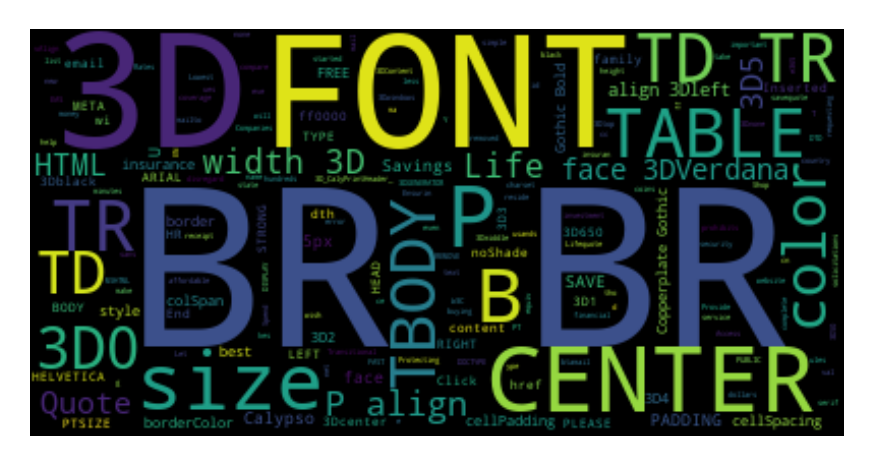

In [56]:
word_cloud = WordCloud().generate(data.at[0, 'MESSAGE'])
plt.figure(figsize = (3.5,3.5), dpi = 300)
plt.imshow(word_cloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

In [57]:

# downloading entire novel

nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\91998\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\91998\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [58]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)


260819

In [59]:
type(example_corpus) # token

nltk.corpus.reader.util.StreamBackedCorpusView

In [60]:
word_list = [''.join(word) for word in example_corpus]
word_list # list of words


['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.',
 '(',
 'Supplied',
 'by',
 'a',
 'Late',
 'Consumptive',
 'Usher',
 'to',
 'a',
 'Grammar',
 'School',
 ')',
 'The',
 'pale',
 'Usher',
 '--',
 'threadbare',
 'in',
 'coat',
 ',',
 'heart',
 ',',
 'body',
 ',',
 'and',
 'brain',
 ';',
 'I',
 'see',
 'him',
 'now',
 '.',
 'He',
 'was',
 'ever',
 'dusting',
 'his',
 'old',
 'lexicons',
 'and',
 'grammars',
 ',',
 'with',
 'a',
 'queer',
 'handkerchief',
 ',',
 'mockingly',
 'embellished',
 'with',
 'all',
 'the',
 'gay',
 'flags',
 'of',
 'all',
 'the',
 'known',
 'nations',
 'of',
 'the',
 'world',
 '.',
 'He',
 'loved',
 'to',
 'dust',
 'his',
 'old',
 'grammars',
 ';',
 'it',
 'somehow',
 'mildly',
 'reminded',
 'him',
 'of',
 'his',
 'mortality',
 '.',
 '"',
 'While',
 'you',
 'take',
 'in',
 'hand',
 'to',
 'school',
 'others',
 ',',
 'and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale',
 '-',
 'fish',
 'is',
 'to',
 'be',
 

In [61]:
novel_as_string = ' '.join(word_list)


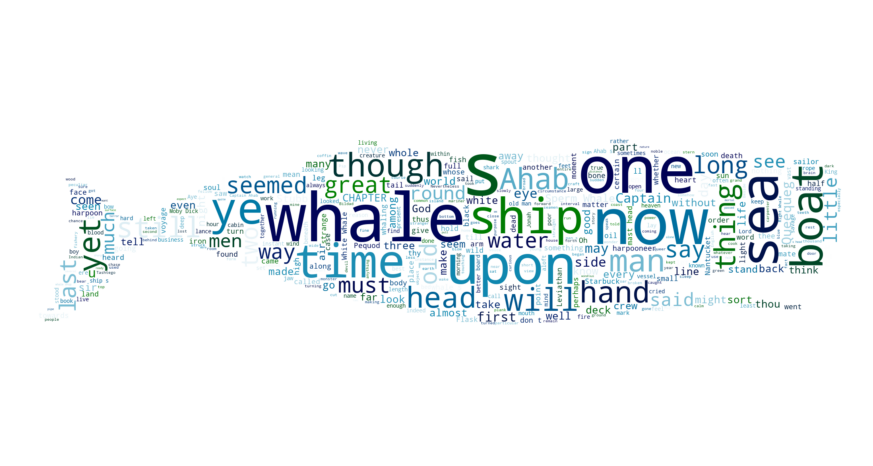

In [62]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode = 'RGB', size = icon.size, color = (255, 255, 255) )
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # image to array


word_cloud = WordCloud(mask = rgb_array, max_words = 400, background_color = 'white',
colormap = 'ocean')
word_cloud.generate(novel_as_string)
plt.figure(figsize = (3.5,3.5), dpi = 300)
plt.imshow(word_cloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

In [63]:
rgb_array[200, 2047]


array([255, 255, 255], dtype=uint8)

## Word Cloud of Ham and Spam 

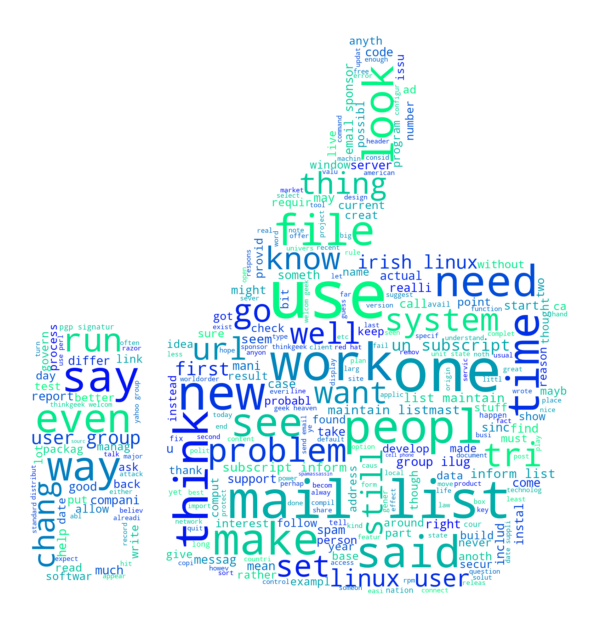

In [64]:
icon = Image.open(THUMPS_UP_FILE)
image_mask = Image.new(mode = 'RGB', size = icon.size, color = (255, 255, 255) )
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # image to array

# Generate the text as a string for the word cloud

ham_str = ' '.join(flat_list_ham)


word_cloud = WordCloud(mask = rgb_array, max_words = 300, background_color = 'white',
colormap = 'winter')
word_cloud.generate(ham_str)
plt.figure(figsize = (2.5,2.5), dpi = 300)
plt.imshow(word_cloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

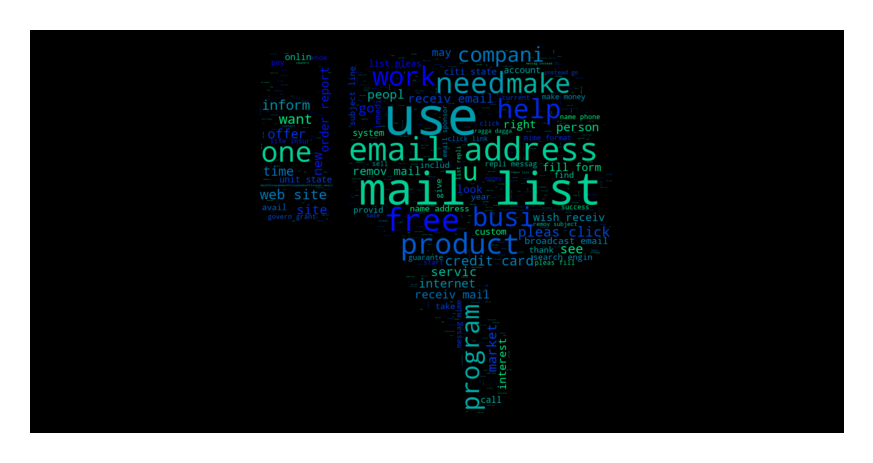

In [65]:
icon = Image.open(THUMPS_DOWN_FILE)
image_mask = Image.new(mode = 'RGB', size = icon.size, color = (255, 255, 255) )
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # image to array

# Generate the text as a string for the word cloud

spam_str = ' '.join(flat_list_spam)


word_cloud = WordCloud(mask = rgb_array, max_words = 500, background_color = 'black',
colormap = 'winter')
word_cloud.generate(spam_str)
plt.figure(figsize = (3.5,3.5), dpi = 300)
plt.imshow(word_cloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [66]:
stemmed_nested_list = data.MESSAGE.apply(clean_message)
flat_stemmed_list = [item for subslist in stemmed_nested_list for item in subslist]

c:\Users\91998\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Users\91998\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [67]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()


Nr of unique words 27332


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [68]:
# the most common 2,500 words out of the total. 

frequent_words = unique_words[0: VOCAB_SIZE]
print('Most common words: \n', frequent_words[:2] )


Most common words: 
 http    10660
use      5019
dtype: int64


### Cleaning Vocabulary DataFrame with a WORD_ID

In [69]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()


,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


### Save the Vocabulary as a CSV File

In [70]:
vocab.to_csv(WORD_ID_FILE,index_label= vocab.index.name, header = vocab.VOCAB_WORD.name )

## Exercise: Checking if a Word is Part of the Vocabulary

#### Challenge: Write a line of code that checks if a particular word is part of the vocabulary. Your code should return True if the word is among the 2500 words that comprise the vocabulary, and False otherwise. Check these words: 
#### 'machine','learning','fun','learn', 'data','science', 'app', 'brewery'

In [71]:
any( vocab.VOCAB_WORD == 'http') #ineffeicient

True

In [72]:
'machin' in set(vocab.VOCAB_WORD) # better way 

True

##### Exercise: Find the Emal with the Most Number of Words
##### challenge: print out the number of words in the longest email (after cleaning and stemming).
##### Note the longest email's position in the list of cleaned emails. Print out the stemmed
##### list of words in the longest email. Print out the longest email from the data dataframe


In [73]:
list_of_emails_after_cleaning = data.MESSAGE.apply(clean_message)

c:\Users\91998\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Users\91998\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [74]:
max_len = 0
max_len_email = [len(item) for item in list_of_emails_after_cleaning]
lst = max_len_email.index(max(max_len_email))
print(max(max_len_email))
print(lst)
print(len(list_of_emails_after_cleaning[lst]))
list_of_emails_after_cleaning[lst]



7671
5775
7671


['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [75]:
type(stemmed_nested_list)
type(stemmed_nested_list.tolist())

list

In [76]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [77]:
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [78]:
word_columns_df.shape


(5796, 7671)

## Splitting the Data into a training and Testing Dataset

In [79]:
# Challenge: Can you split the data into a training and testing set? Set the test size at 30%.
# The training data should include 4057 emails. Use a seed value of 42 to shuffle the data. 

In [80]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size= 0.3, random_state = 42)

In [81]:
print(X_train.shape[0] / word_columns_df.shape[0])

0.6999654934437544


In [82]:
type(X_train)

pandas.core.frame.DataFrame

In [83]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [84]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

In [85]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [86]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [87]:
word_index = pd.Index(vocab.VOCAB_WORD)
print(word_index)

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'fashion', 'invalid', 'raid', 'distributor', 'tobacco', 'till', 'corn',
       'analog', 'apach', 'overnight'],
      dtype='object', name='VOCAB_WORD', length=2500)


In [88]:
word_index.get_loc('thu')

393

In [89]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.

    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of the words ordered by word id
    labels: category as a series (y_train or _test)

    """

    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []

    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {'LABEL': category, 'DOC_ID': doc_id,
                'OCCURENCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)



    return pd.DataFrame(dict_list)

In [90]:
 
%%time

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: total: 18min 21s
Wall time: 19min 8s


In [92]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1239
2,0,4844,1,504
3,0,4844,1,308
4,0,4844,1,254


In [91]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429179,1,860,1,47
429180,1,860,1,1431
429181,1,860,1,26
429182,1,860,1,21
429183,1,860,1,126


In [95]:
sparse_train_df.shape

(429184, 4)

### Combine Occurences with the pandas groupby() Method

In [96]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

In [97]:
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [98]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [99]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258327,5795,2032,0,2
258328,5795,2037,0,1
258329,5795,2271,0,1
258330,5795,2348,0,1
258331,5795,2379,0,1


In [100]:
vocab.at[2037, 'VOCAB_WORD']

'encount'

In [101]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [102]:
train_grouped.shape

(258332, 4)

### Save Training data as .txt file

In [109]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d' )
train_grouped.to_csv(TRAINING_DATA_FILE_CSV)

In [107]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

#### challenge create a sparse matrix for the test data. Group the occurence of the same word in the same email 

In [111]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [112]:
sparse_test_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4675,1,89
1,0,4675,1,299
2,0,4675,1,546
3,0,4675,1,84
4,0,4675,1,466


In [113]:
sparse_test_df.tail()


,LABEL,DOC_ID,OCCURENCE,WORD_ID
203399,0,4354,1,1
203400,0,4354,1,431
203401,0,4354,1,51
203402,0,4354,1,87
203403,0,4354,1,0


In [114]:
sparse_test_df.shape

(203404, 4)

In [115]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
8      2       1              1
       3       1              4
       4       1              2
       5       1              1
       6       1              2

In [119]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [120]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d' )


## Pre-Processing Subtleities and checking your Understanding

We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the sae? If not, which emails were excluded and why? Compare the DOC_ID values to find out. 

In [121]:
train_grouped.columns

Index(['level_0', 'index', 'DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [135]:
len(train_grouped['DOC_ID'].value_counts())



4013

In [136]:
train_grouped['DOC_ID'].value_counts().shape


(4013,)

In [134]:
len(test_grouped['DOC_ID'].value_counts())

1724

In [137]:
train_grouped['DOC_ID'].value_counts().shape

(4013,)

In [138]:
train_doc_ids = set(train_grouped.DOC_ID)

In [140]:
test_doc_ids = set(test_grouped.DOC_ID)

In [141]:
len(test_doc_ids)

1724

In [143]:
len(train_doc_ids)

4013

In [144]:
# which emails are missing using set operation difference

In [145]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [149]:
data.at[1544, 'MESSAGE']

'.\n\n\n\nukqdrblkougooeoffnxsmbowei\n\n\n\n\n'

In [150]:
set(X_train.index.values) - train_doc_ids

{22,
 38,
 73,
 77,
 86,
 91,
 94,
 114,
 127,
 138,
 186,
 193,
 197,
 205,
 206,
 302,
 328,
 335,
 338,
 369,
 402,
 545,
 546,
 766,
 875,
 878,
 924,
 929,
 939,
 940,
 965,
 983,
 988,
 1035,
 1100,
 1164,
 1170,
 1234,
 1248,
 1313,
 1360,
 1686,
 1846,
 1878}

#### Reason no words in word-set in those emails therefore


data.loc[14]

In [157]:
data.loc[1313]

MESSAGE      \n\n------=_NextPart_000_00E6_61E42E2B.C1032A6...
CATEGORY                                                     1
FILE_NAME               00818.3939063d91d49a0c8e7d01efb2fb95a1
Name: 1313, dtype: object

In [159]:
print(clean_message(data.at[1313, 'MESSAGE']))

[]
